In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Clone the Detectron2 repository
!git clone https://github.com/facebookresearch/detectron2.git

# Navigate to the Detectron2 directory
%cd detectron2

# Install Detectron2
!pip install -e .


Cloning into 'detectron2'...
remote: Enumerating objects: 15806, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 15806 (delta 22), reused 38 (delta 9), pack-reused 15743 (from 1)
Receiving objects: 100% (15806/15806), 6.38 MiB | 20.60 MiB/s, done.
Resolving deltas: 100% (11518/11518), done.
/kaggle/working/detectron2
Obtaining file:///kaggle/working/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.

In [2]:
import sys
import os
import argparse
import numpy as np
import cv2
import random
import json

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import ColorMode

# Step 4: Set up argument parser only for script environments
def parse_args():
    parser = argparse.ArgumentParser(description='Train and test Detectron2')
    parser.add_argument('--mode', dest='mode', help='choose to train or to test', default='train', type=str)
    parser.add_argument('--lr', dest='learning_rate', default=0.0125, type=float)
    parser.add_argument('--it', dest='max_iteration', default=1500, type=int)
    parser.add_argument('--workers', dest='number_of_workers', default=2, type=int)
    parser.add_argument('--ims_per_batch', dest='ims_per_batch', default=4, type=int)
    parser.add_argument('--eval_period', dest='evaluation_period', default=500, type=int)
    parser.add_argument('--batch_size', dest='batch_size', default=256, type=int)

    # Ignore unwanted arguments for Jupyter environment
    if "ipykernel" in sys.modules:
        # For notebook environments, we don't use command-line arguments
        return parser.parse_args([])  # Return empty args so we don't parse anything extra
    else:
        return parser.parse_args(sys.argv[1:])

def register_data():
    # Replace paths with actual locations of your dataset on Kaggle
    register_coco_instances("PKLot_train", {}, "/kaggle/input/pklot-detectron2/train/_annotations.coco.json", "/kaggle/input/pklot-detectron2/train")
    register_coco_instances("PKLot_valid", {}, "/kaggle/input/pklot-detectron2/valid/_annotations.coco.json", "/kaggle/input/pklot-detectron2/valid")
    register_coco_instances("PKLot_test", {}, "/kaggle/input/pklot-detectron2/test/_annotations.coco.json", "/kaggle/input/pklot-detectron2/test")

def visualize_data():
    dataset_dicts = DatasetCatalog.get("PKLot_train")
    for d in random.sample(dataset_dicts, 3):
        print(d["annotations"])
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("PKLot_train"), scale=0.5)
        out = visualizer.draw_dataset_dict(d)
        cv2_imshow(out.get_image()[:, :, ::-1])

def config():
    args = parse_args()
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ("PKLot_train",)
    cfg.DATASETS.TEST = ("PKLot_valid",)
    cfg.DATALOADER.NUM_WORKERS = args.number_of_workers
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = args.ims_per_batch
    cfg.SOLVER.BASE_LR = args.learning_rate  # pick a good LR
    cfg.SOLVER.MAX_ITER = args.max_iteration  # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    cfg.SOLVER.STEPS = []  # do not decay learning rate
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = args.batch_size  # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # Adjust number of classes as per your dataset
    cfg.TEST.EVAL_PERIOD = args.evaluation_period
    return cfg

def train():
    cfg = config()
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    trainer.train()

def test():
    cfg = config()
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    predictor = DefaultPredictor(cfg)
    test_set = DatasetCatalog.get("PKLot_test")
    for d in random.sample(test_set, 7):
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1],
                       metadata=MetadataCatalog.get("PKLot_test"),
                       scale=0.5,
                       instance_mode=ColorMode.IMAGE_BW)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        img = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_RGBA2RGB)
        plt.imsave(os.path.join(os.path.join(cfg.OUTPUT_DIR, 'visualization'), str(d["image_id"]) + '.png'), img)

if __name__ == '__main__':
    args = parse_args()
    register_data()
    if args.mode == 'train':
        train()
    elif args.mode == 'test':
        test()


[11/19 02:04:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 120MB/s]                             


[11/19 02:04:54 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/19 02:05:09 d2.utils.events]:  eta: 0:14:27  iter: 19  total_loss: 2.567  loss_cls: 1.195  loss_box_reg: 0.7243  loss_rpn_cls: 0.4146  loss_rpn_loc: 0.2142    time: 0.5913  last_time: 0.5790  data_time: 0.0217  last_data_time: 0.0116   lr: 0.00024976  max_mem: 3066M
[11/19 02:05:35 d2.utils.events]:  eta: 0:14:29  iter: 39  total_loss: 1.857  loss_cls: 0.7539  loss_box_reg: 0.7139  loss_rpn_cls: 0.2081  loss_rpn_loc: 0.1679    time: 0.6098  last_time: 0.5663  data_time: 0.0115  last_data_time: 0.0108   lr: 0.00049951  max_mem: 3066M
[11/19 02:05:47 d2.utils.events]:  eta: 0:14:25  iter: 59  total_loss: 1.637  loss_cls: 0.6064  loss_box_reg: 0.709  loss_rpn_cls: 0.1498  loss_rpn_loc: 0.146    time: 0.6140  last_time: 0.6719  data_time: 0.0110  last_data_time: 0.0097   lr: 0.00074926  max_mem: 3069M
[11/19 02:06:00 d2.utils.events]:  eta: 0:14:27  iter: 79  total_loss: 1.482  loss_cls: 0.5164  loss_box_reg: 0.6959  loss_rpn_cls: 0.1169  loss_rpn_loc: 0.1397    time: 0.6178  last_time

[11/19 02:31:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/detectron2/output/model_final.pth ...


/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

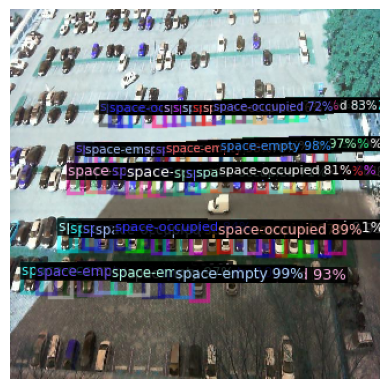

In [3]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# 1. Set up the configuration for inference (testing the trained model)
def setup_cfg():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ("PKLot_train",)  # Can be any dataset, even just used for inference
    cfg.DATASETS.TEST = ("PKLot_valid",)  # Can be any dataset, even just used for inference
    cfg.MODEL.WEIGHTS = "/kaggle/working/detectron2/output/model_final.pth"  # Path to your trained model
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Confidence threshold for predictions
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # Adjust based on your dataset
    cfg.TEST.EVAL_PERIOD = 500  # Evaluation frequency during training
    return cfg

# 2. Create predictor for testing
def create_predictor(cfg):
    predictor = DefaultPredictor(cfg)
    return predictor

# 3. Load a sample image and run inference
def run_inference_on_image(predictor, image_path):
    # Read the input image
    im = cv2.imread(image_path)
    
    # Perform inference
    outputs = predictor(im)
    
    # Visualize the predictions
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("PKLot_valid"), scale=0.5)
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # Convert the output image to RGB (from BGR) and show it
    result_image = out.get_image()[:, :, ::-1]
    plt.imshow(result_image)
    plt.axis('off')
    plt.show()

# 4. Example usage
if __name__ == "__main__":
    # Setup configuration
    cfg = setup_cfg()

    # Create the predictor (loading the trained model)
    predictor = create_predictor(cfg)

    # Path to the sample image for testing
    image_path = "/kaggle/input/pklot-detectron2/train/2012-09-11_15_16_58_jpg.rf.605705be3d712e3d33d693bebdc77518.jpg"  # Change to the image you want to test

    # Run inference on the image
    run_inference_on_image(predictor, image_path)
